## Problem Cats vs. Dogs 

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.applications import ResNet50,Xception,VGG16,VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [2]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 10
NUM_CLASSES = 2
SAMPLE_SIZE = 20000
PATH = '/'
TRAIN_FOLDER = './train/'
TEST_FOLDER =  './test/'
IMG_SIZE = 224

In [3]:
train_image_path = os.path.join(PATH, "train.zip")
test_image_path = os.path.join(PATH, "test.zip")
import zipfile
with zipfile.ZipFile(train_image_path,"r") as z:
    z.extractall(".")
with zipfile.ZipFile(test_image_path,"r") as z:
    z.extractall(".")

In [4]:
train_image_list = os.listdir('./train/')[0:SAMPLE_SIZE]
test_image_list = os.listdir('./test/')

In [5]:
def label_pet_image_one_hot_encoder(img):
    pet = img.split('.')[-3]
    if pet == 'cat': return [1,0]
    elif pet == 'dog': return [0,1]

In [6]:
def process_data(data_image_list, DATA_FOLDER, isTrain=True):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        if(isTrain):
            label = label_pet_image_one_hot_encoder(img)
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


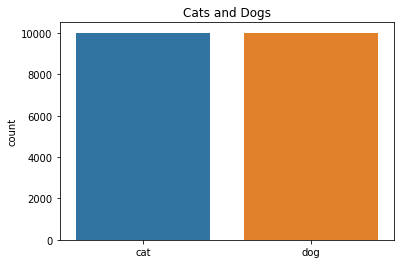

In [7]:
def plot_image_list_count(data_image_list):
    labels = []
    for img in data_image_list:
        labels.append(img.split('.')[-3])
    sns.countplot(labels)
    plt.title('Cats and Dogs')
    
plot_image_list_count(train_image_list)

In [8]:
train = process_data(train_image_list, TRAIN_FOLDER)

100%|██████████| 20000/20000 [00:56<00:00, 355.89it/s]


In [9]:
test = process_data(test_image_list, TEST_FOLDER, False)


100%|██████████| 12500/12500 [00:34<00:00, 358.93it/s]


In [10]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [32]:
model_ResNet50 = Sequential()
model_ResNet50.add(ResNet50(
    weights='imagenet',
    pooling='max',
    include_top=False,
                   
))
model_ResNet50.add(Dense(NUM_CLASSES, activation='sigmoid'))

model_ResNet50.layers[0].trainable = False


In [33]:
model_ResNet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
model_ResNet50.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
X_train.shape

(10000, 224, 224, 3)

In [16]:
y_train

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [35]:
train_model = model_ResNet50.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
157/157 [==============================] - 809s 5s/step - loss: 0.2648 - accuracy: 0.9576 - val_loss: 0.1100 - val_accuracy: 0.9807
Epoch 2/10
157/157 [==============================] - 768s 5s/step - loss: 0.1033 - accuracy: 0.9813 - val_loss: 0.0909 - val_accuracy: 0.9820
Epoch 3/10
157/157 [==============================] - 775s 5s/step - loss: 0.0697 - accuracy: 0.9856 - val_loss: 0.1469 - val_accuracy: 0.9750
Epoch 4/10
157/157 [==============================] - 785s 5s/step - loss: 0.0654 - accuracy: 0.9855 - val_loss: 0.1077 - val_accuracy: 0.9833
Epoch 5/10
157/157 [==============================] - 760s 5s/step - loss: 0.0450 - accuracy: 0.9899 - val_loss: 0.1253 - val_accuracy: 0.9825
Epoch 6/10
157/157 [==============================] - 766s 5s/step - loss: 0.0314 - accuracy: 0.9924 - val_loss: 0.0799 - val_accuracy: 0.9836
Epoch 7/10
157/157 [==============================] - 760s 5s/step - loss: 0.0257 - accuracy: 0.9957 - val_loss: 0.1170 - val_accuracy: 0.9801

In [36]:
score =  model_ResNet50.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.08812825381755829
Validation accuracy: 0.9836000204086304


In [23]:
model_Xception_1 = Sequential()
model_Xception_1.add(Xception(
 
    weights='imagenet',
     pooling='max',
    include_top=False,

))
model_Xception_1.add(Dense(NUM_CLASSES, activation='softmax'))

model_Xception_1.layers[0].trainable = False
model_Xception_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
train_model_Xcept = model_Xception_1.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
157/157 [==============================] - 921s 6s/step - loss: 3408.6267 - accuracy: 0.5286 - val_loss: 711.4897 - val_accuracy: 0.6251
Epoch 2/10
157/157 [==============================] - 914s 6s/step - loss: 3047.3533 - accuracy: 0.5534 - val_loss: 5119.3457 - val_accuracy: 0.5317
Epoch 3/10
157/157 [==============================] - 903s 6s/step - loss: 2787.9124 - accuracy: 0.5673 - val_loss: 4845.9502 - val_accuracy: 0.4950
Epoch 4/10
157/157 [==============================] - 900s 6s/step - loss: 2735.8745 - accuracy: 0.5687 - val_loss: 1658.1110 - val_accuracy: 0.5683
Epoch 5/10
157/157 [==============================] - 888s 6s/step - loss: 2881.5237 - accuracy: 0.5681 - val_loss: 7915.5791 - val_accuracy: 0.5171
Epoch 6/10
157/157 [==============================] - 889s 6s/step - loss: 2750.0068 - accuracy: 0.5731 - val_loss: 1792.4728 - val_accuracy: 0.5779
Epoch 7/10
157/157 [==============================] - 912s 6s/step - loss: 2633.6035 - accuracy: 0.5778 - v

In [27]:
score_Xcept =  model_Xception_1.evaluate(X_val, y_val, verbose=0)


Validation loss: 0.37493592500686646
Validation accuracy: 0.9868999719619751


In [29]:
print('Validation loss:', score_Xcept[0])
print('Validation accuracy:', score_Xcept[1])

Validation loss: 1607.6888427734375
Validation accuracy: 0.5921000242233276


In [ ]:
pred_list = []
img_list = []
for img in tqdm(test):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = model_ResNet50.predict([data])[0]
    img_list.append(img_idx)
    pred_list.append(predicted[1])
    
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission.csv", index=False)